## Dependencias 

In [52]:
import numpy as np 
import pandas as pd 
from google.cloud import bigquery

from CreditScoringToolkit.frequency_table import frequency_table #pip install woe-credit-scoring

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score,roc_curve


from functools import reduce

from varclushi import VarClusHi

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf

cf.go_offline()

## Lectura de datos 

In [2]:
def run_bq_query(sql_file_path, gcp_credentials_path, project_id):
    """
    Executes a BigQuery SQL query from a file and returns the results as a pandas DataFrame.
    Args:
        sql_file_path (str): The file path to the SQL query file.
        gcp_credentials_path (str): The file path to the Google Cloud Platform service account JSON credentials.
        project_id (str): The Google Cloud Platform project ID.
    Returns:
        pandas.DataFrame: The results of the SQL query as a pandas DataFrame.
    """
    # Initialize a BigQuery client
    client = bigquery.Client.from_service_account_json(gcp_credentials_path, project=project_id)
    
    # Read the SQL query from the file
    with open(sql_file_path, 'r') as file:
        query = file.read()
    
    # Run the query and convert the results to a pandas DataFrame
    query_job = client.query(query)
    results = query_job.result().to_dataframe()
    
    return results

In [49]:
train = run_bq_query('query_train.sql', '../../creds/sist_int.json', 'demos-431019')
valid = run_bq_query('query_valid.sql', '../../creds/sist_int.json', 'demos-431019')
train.shape,valid.shape

((307634, 23), (26972, 23))

In [50]:
display(train.head(2))
display(valid.head(2))

,id,fh,x_ing_ult_3m,x_ing_ult_6m,x_ing_ult_9m,x_ing_ult_12m,x_num_horas_trabajadas_ult3m,x_num_horas_trabajadas_ult6m,x_num_horas_trabajadas_ult9m,x_num_horas_trabajadas_ult12m,...,x_prom_viajes_mes_ult12m,x_prom_dist_mes_ult3m,x_prom_dist_mes_ult6m,x_prom_dist_mes_ult9m,x_prom_dist_mes_ult12m,x_tarif_x_hora_ult3m,x_tarif_x_hora_ult6m,x_tarif_x_hora_ult9m,x_tarif_x_hora_ult12m,tgt
0,4096,2020-04-01,20493.58,52751.72,83995.58,108791.21,291.149167,753.954167,1230.439722,1613.948611,...,485.750000,2083.166667,2673.46,2826.220000,2743.522500,68.839243,69.277214,68.047192,67.188807,0
1,4096,2020-06-01,12883.76,41233.06,74214.94,103974.28,196.853889,594.881111,1082.161667,1528.715556,...,489.916667,1244.483333,2069.61,2475.592222,2600.456667,64.908601,68.057745,67.932301,67.627577,0


,id,fh,x_ing_ult_3m,x_ing_ult_6m,x_ing_ult_9m,x_ing_ult_12m,x_num_horas_trabajadas_ult3m,x_num_horas_trabajadas_ult6m,x_num_horas_trabajadas_ult9m,x_num_horas_trabajadas_ult12m,...,x_prom_viajes_mes_ult12m,x_prom_dist_mes_ult3m,x_prom_dist_mes_ult6m,x_prom_dist_mes_ult9m,x_prom_dist_mes_ult12m,x_tarif_x_hora_ult3m,x_tarif_x_hora_ult6m,x_tarif_x_hora_ult9m,x_tarif_x_hora_ult12m,tgt
0,1280,2022-09-01,16311.49,33867.51,52187.73,71647.70,199.450000,393.616667,565.533333,770.216667,...,195.583333,1359.500000,1420.616667,1435.422222,1487.816667,80.402343,85.170374,93.187639,93.644723,0
1,1280,2022-06-01,17556.02,35876.24,55336.21,83122.68,194.166667,366.083333,570.766667,834.883333,...,216.666667,1481.733333,1473.383333,1530.588889,1742.408333,89.938404,99.580287,98.058849,99.809225,0


## Limpieza 

### Categorización de variables 

In [51]:
varc = [v for v in train.columns if v[:2]=='x_']
vart = ['tgt']
um = ['id','fh']

## Escalamiento

In [53]:
sc = MinMaxScaler()
sc.fit(train[varc])
train[varc] = sc.transform(train[varc])
valid[varc] = sc.transform(valid[varc])

## Análisis exploratorio de datos 

In [54]:
frequency_table(train,vart)
frequency_table(valid,vart)

****Frequency Table  tgt  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
tgt                                                            
0        300692    0.977434            300692          0.977434
1          6942    0.022566            307634               1.0




****Frequency Table  tgt  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
tgt                                                            
0         26590    0.985837             26590          0.985837
1           382    0.014163             26972               1.0






### Continuo

#### Ausentes 

In [55]:
miss = (train[varc].isna().sum()/len(train))
miss 

x_ing_ult_3m                     0.000000
x_ing_ult_6m                     0.000000
x_ing_ult_9m                     0.000000
x_ing_ult_12m                    0.000000
x_num_horas_trabajadas_ult3m     0.000000
x_num_horas_trabajadas_ult6m     0.000000
x_num_horas_trabajadas_ult9m     0.000000
x_num_horas_trabajadas_ult12m    0.000000
x_prom_viajes_mes_ult3m          0.000000
x_prom_viajes_mes_ult6m          0.000000
x_prom_viajes_mes_ult9m          0.000000
x_prom_viajes_mes_ult12m         0.000000
x_prom_dist_mes_ult3m            0.000000
x_prom_dist_mes_ult6m            0.000000
x_prom_dist_mes_ult9m            0.000000
x_prom_dist_mes_ult12m           0.000000
x_tarif_x_hora_ult3m             0.004606
x_tarif_x_hora_ult6m             0.002454
x_tarif_x_hora_ult9m             0.000917
x_tarif_x_hora_ult12m            0.000000
dtype: float64

In [56]:
train.dropna().shape[0]/train.shape[0]

0.9953938771397179

In [57]:
train = train.dropna().reset_index(drop=True)

#### Distribución

array([[<Axes: title={'center': 'x_ing_ult_3m'}>,
        <Axes: title={'center': 'x_ing_ult_6m'}>,
        <Axes: title={'center': 'x_ing_ult_9m'}>,
        <Axes: title={'center': 'x_ing_ult_12m'}>],
       [<Axes: title={'center': 'x_num_horas_trabajadas_ult3m'}>,
        <Axes: title={'center': 'x_num_horas_trabajadas_ult6m'}>,
        <Axes: title={'center': 'x_num_horas_trabajadas_ult9m'}>,
        <Axes: title={'center': 'x_num_horas_trabajadas_ult12m'}>],
       [<Axes: title={'center': 'x_prom_viajes_mes_ult3m'}>,
        <Axes: title={'center': 'x_prom_viajes_mes_ult6m'}>,
        <Axes: title={'center': 'x_prom_viajes_mes_ult9m'}>,
        <Axes: title={'center': 'x_prom_viajes_mes_ult12m'}>],
       [<Axes: title={'center': 'x_prom_dist_mes_ult3m'}>,
        <Axes: title={'center': 'x_prom_dist_mes_ult6m'}>,
        <Axes: title={'center': 'x_prom_dist_mes_ult9m'}>,
        <Axes: title={'center': 'x_prom_dist_mes_ult12m'}>],
       [<Axes: title={'center': 'x_tarif_x_hora_

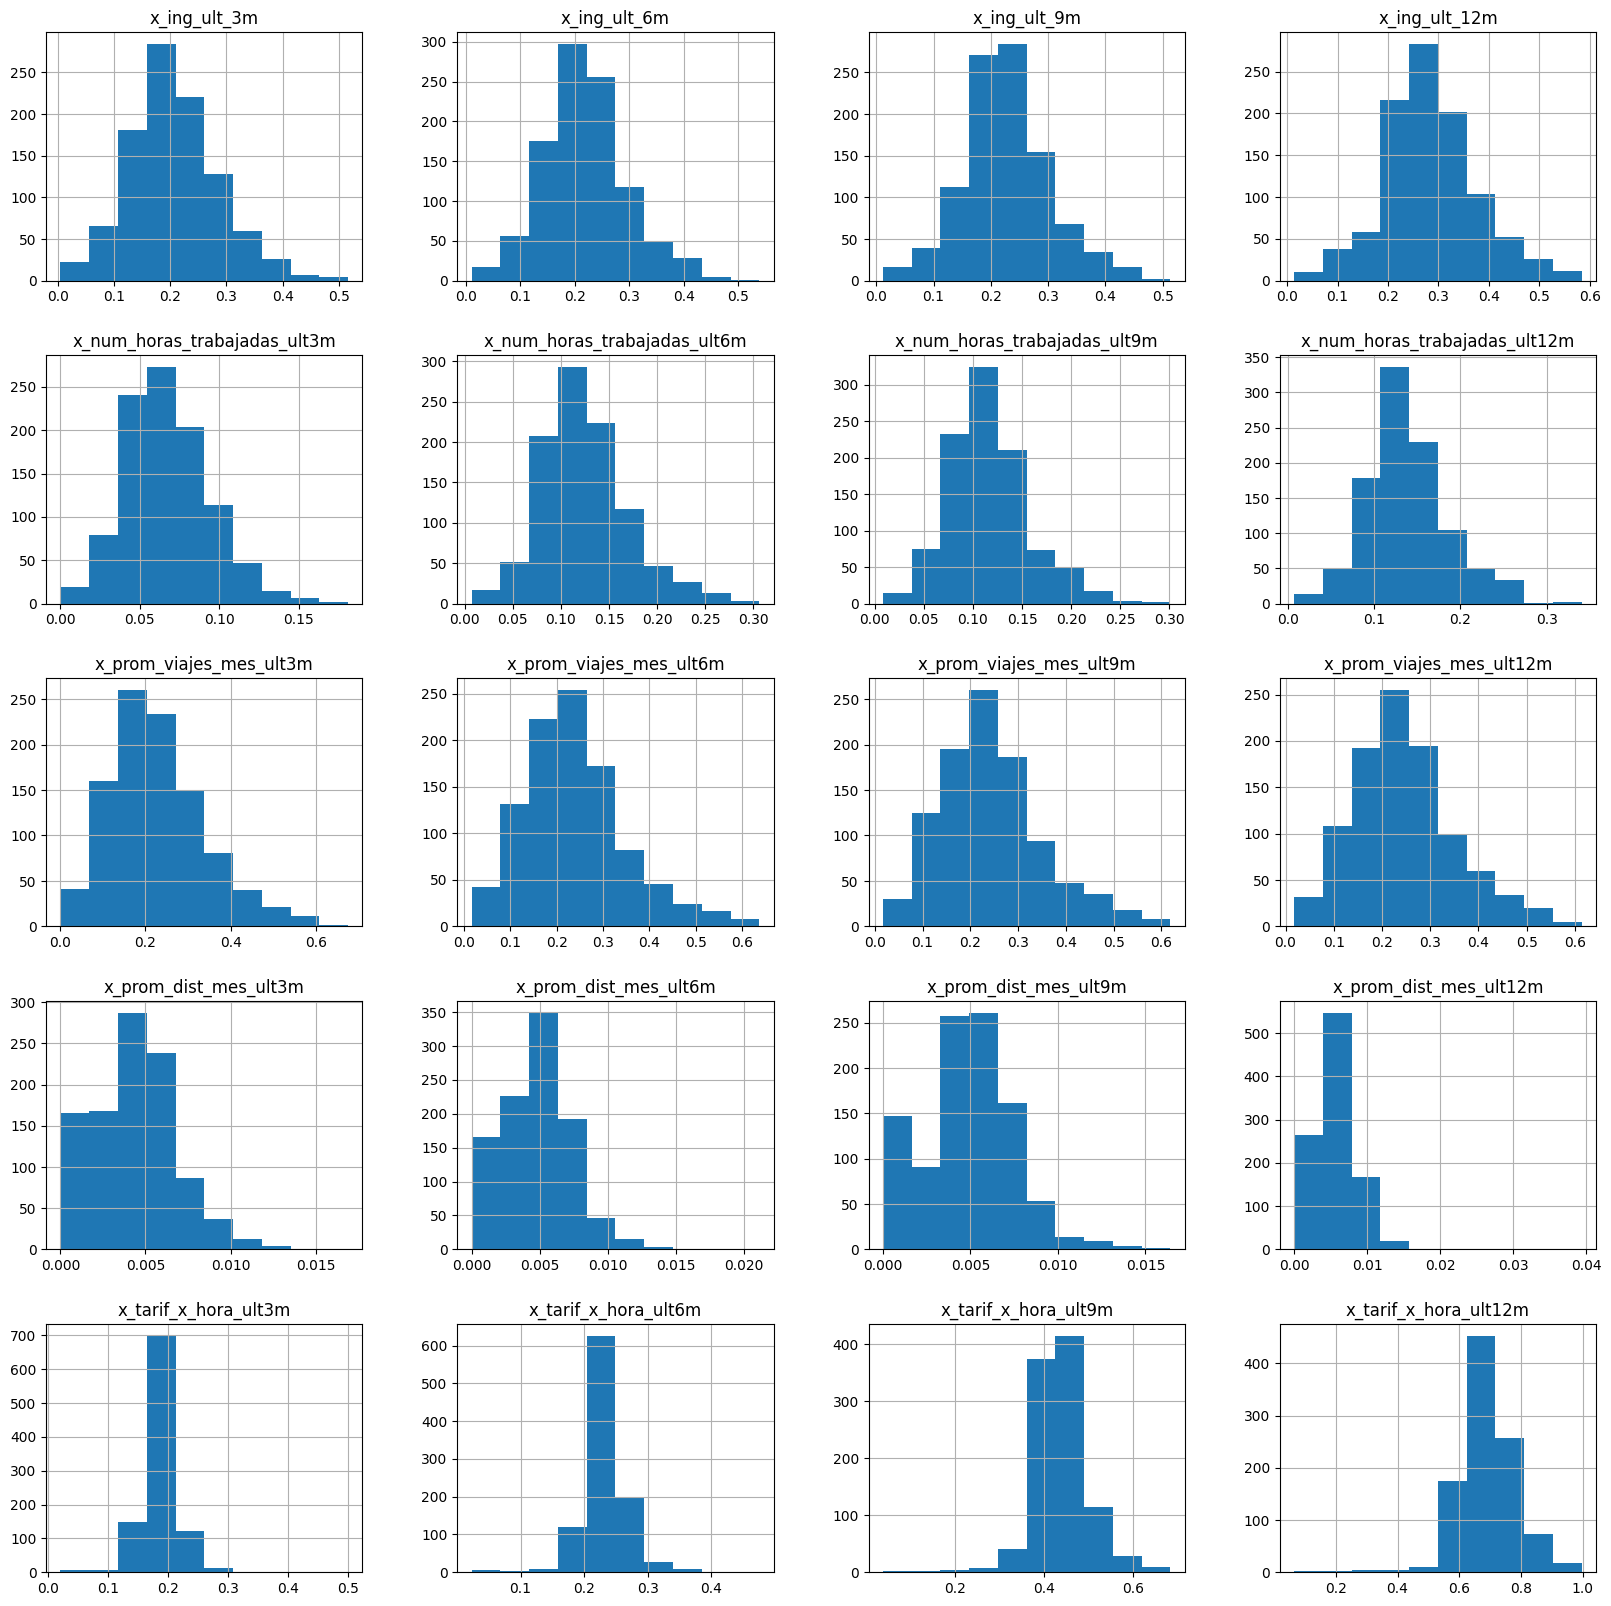

In [58]:
train.sample(1000)[varc].hist(figsize=(20,20))

#### Extremos 

In [59]:
train.drop(train.filter(like='ex_'),axis=1,inplace=True)

In [60]:


# Cerca percentil
for v,li,ls in train[varc].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    train[f'ex_{v}'] = ((train[v]<li)|(train[v]>ls)).astype(int)
train['ex_'] = train.filter(like='ex_').max(axis=1)
frequency_table(train,'ex_')
# Rango inter-cuartil

k = 3 # 2 = moderado, 3 = extremo
iqr = train[varc].describe().T[['25%','75%','mean']]
iqr['iqr'] = iqr['75%']-iqr['25%']
iqr['li'] = iqr['mean']-k*iqr['iqr']
iqr['ls'] = iqr['mean']+k*iqr['iqr']
iqr = iqr[['li','ls']].reset_index()

for v,li,ls in iqr.values:
    train[f'ex_{v}'] = ((train[v]<li)|(train[v]>ls)).astype(int)
train['ex_'] = train.filter(like='ex_').drop('ex_',axis=1).max(axis=1)
frequency_table(train,'ex_')



****Frequency Table  ex_  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
ex_                                                            
0        278455    0.909339            278455          0.909339
1         27762    0.090661            306217          1.000000




****Frequency Table  ex_  ***


     Abs. Freq.  Rel. Freq.  Cumm. Abs. Freq.  Cumm. Rel. Freq.
ex_                                                            
0        295929    0.966403            295929          0.966403
1         10288    0.033597            306217          1.000000






In [61]:
train = train.loc[train['ex_']==0].reset_index(drop=True)

array([[<Axes: title={'center': 'x_ing_ult_3m'}>,
        <Axes: title={'center': 'x_ing_ult_6m'}>,
        <Axes: title={'center': 'x_ing_ult_9m'}>,
        <Axes: title={'center': 'x_ing_ult_12m'}>],
       [<Axes: title={'center': 'x_num_horas_trabajadas_ult3m'}>,
        <Axes: title={'center': 'x_num_horas_trabajadas_ult6m'}>,
        <Axes: title={'center': 'x_num_horas_trabajadas_ult9m'}>,
        <Axes: title={'center': 'x_num_horas_trabajadas_ult12m'}>],
       [<Axes: title={'center': 'x_prom_viajes_mes_ult3m'}>,
        <Axes: title={'center': 'x_prom_viajes_mes_ult6m'}>,
        <Axes: title={'center': 'x_prom_viajes_mes_ult9m'}>,
        <Axes: title={'center': 'x_prom_viajes_mes_ult12m'}>],
       [<Axes: title={'center': 'x_prom_dist_mes_ult3m'}>,
        <Axes: title={'center': 'x_prom_dist_mes_ult6m'}>,
        <Axes: title={'center': 'x_prom_dist_mes_ult9m'}>,
        <Axes: title={'center': 'x_prom_dist_mes_ult12m'}>],
       [<Axes: title={'center': 'x_tarif_x_hora_

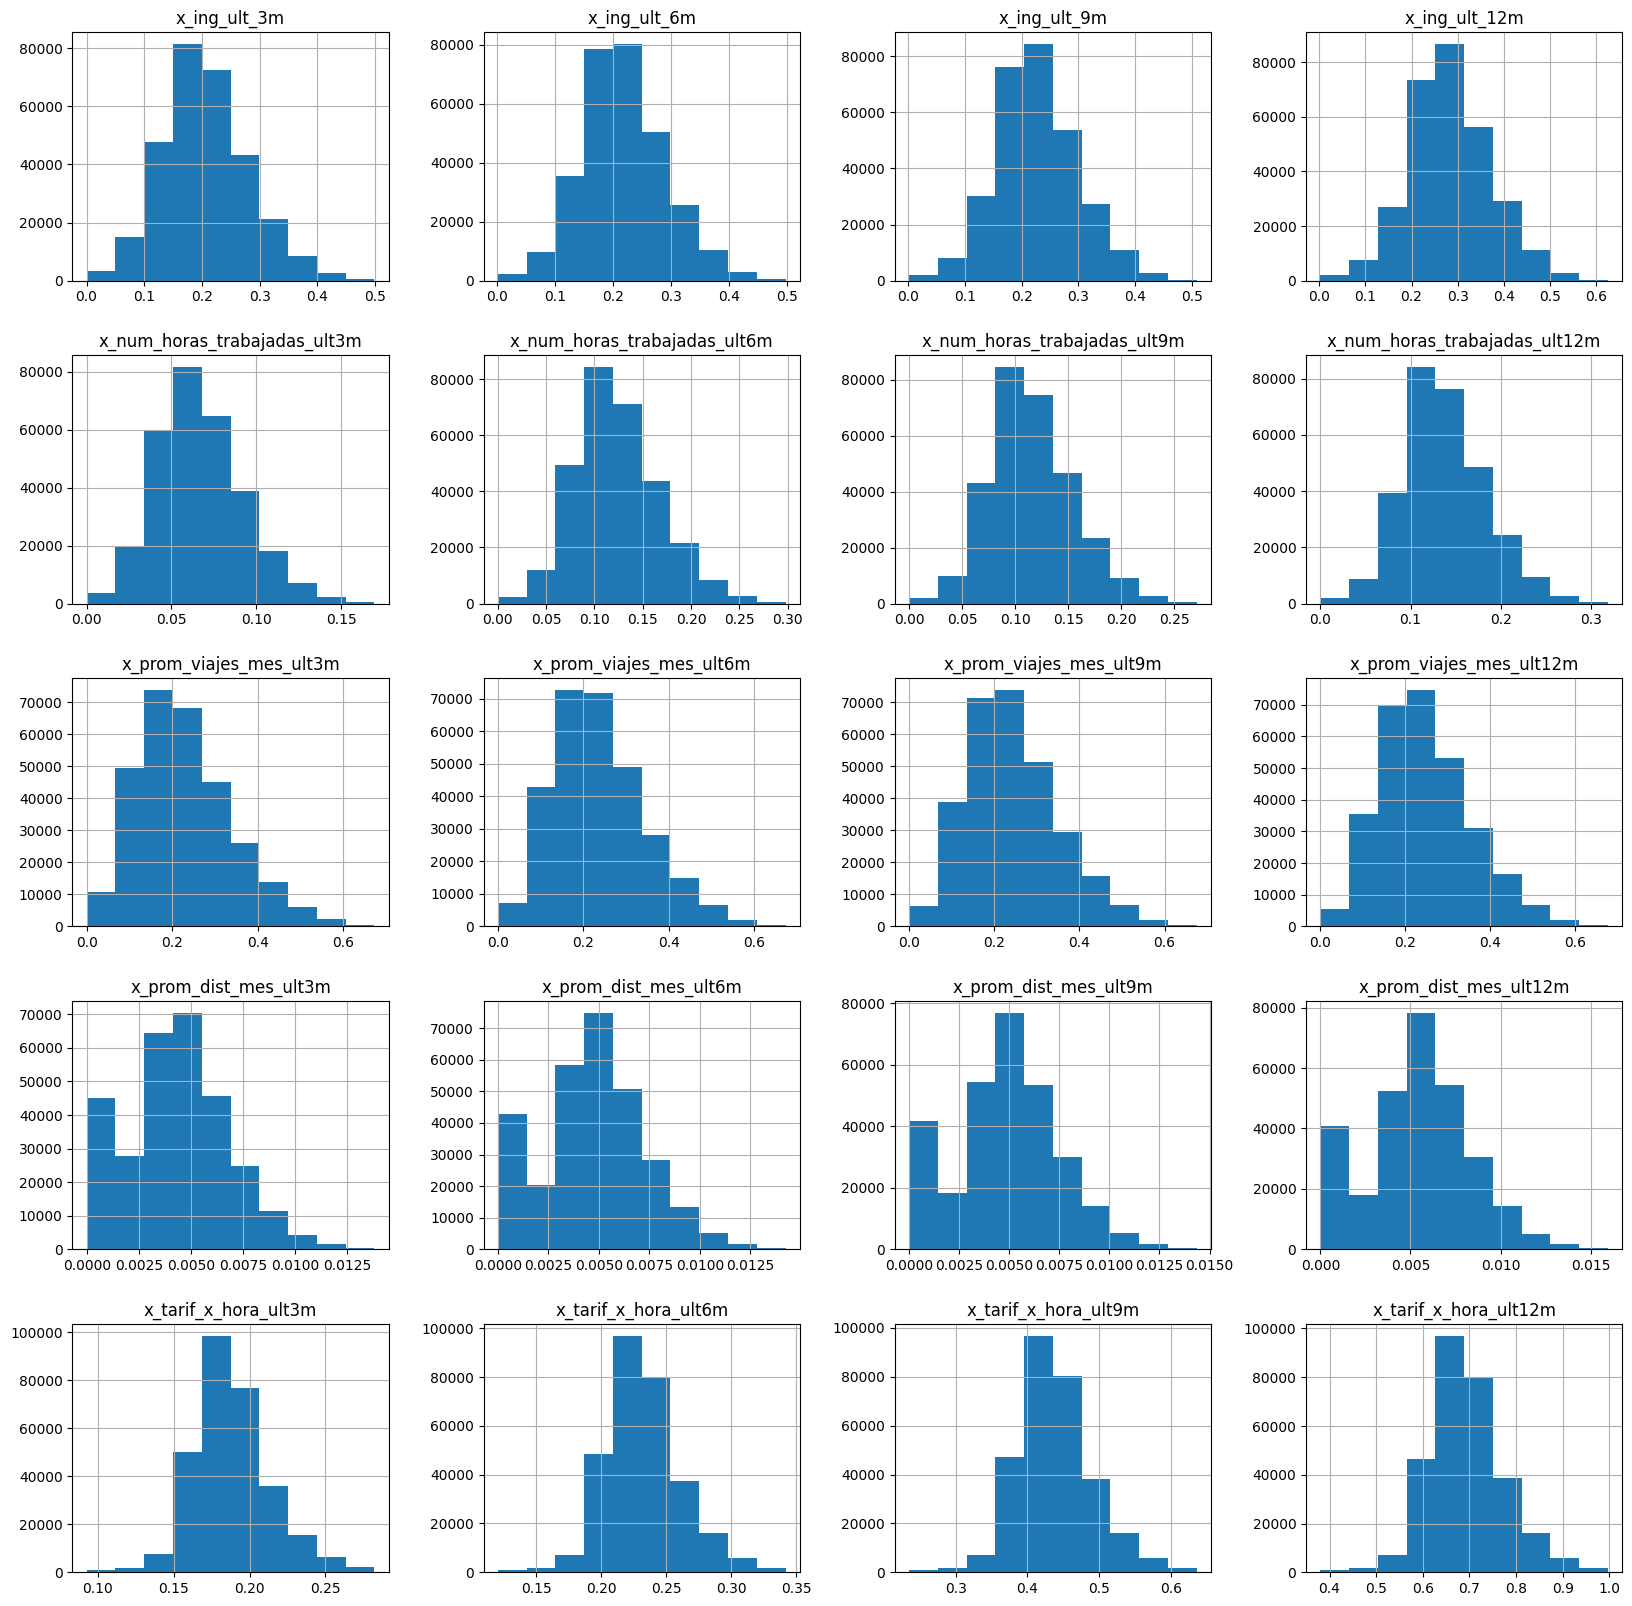

In [62]:
train[varc].hist(figsize=(20,20))

#### Multicolinealidad

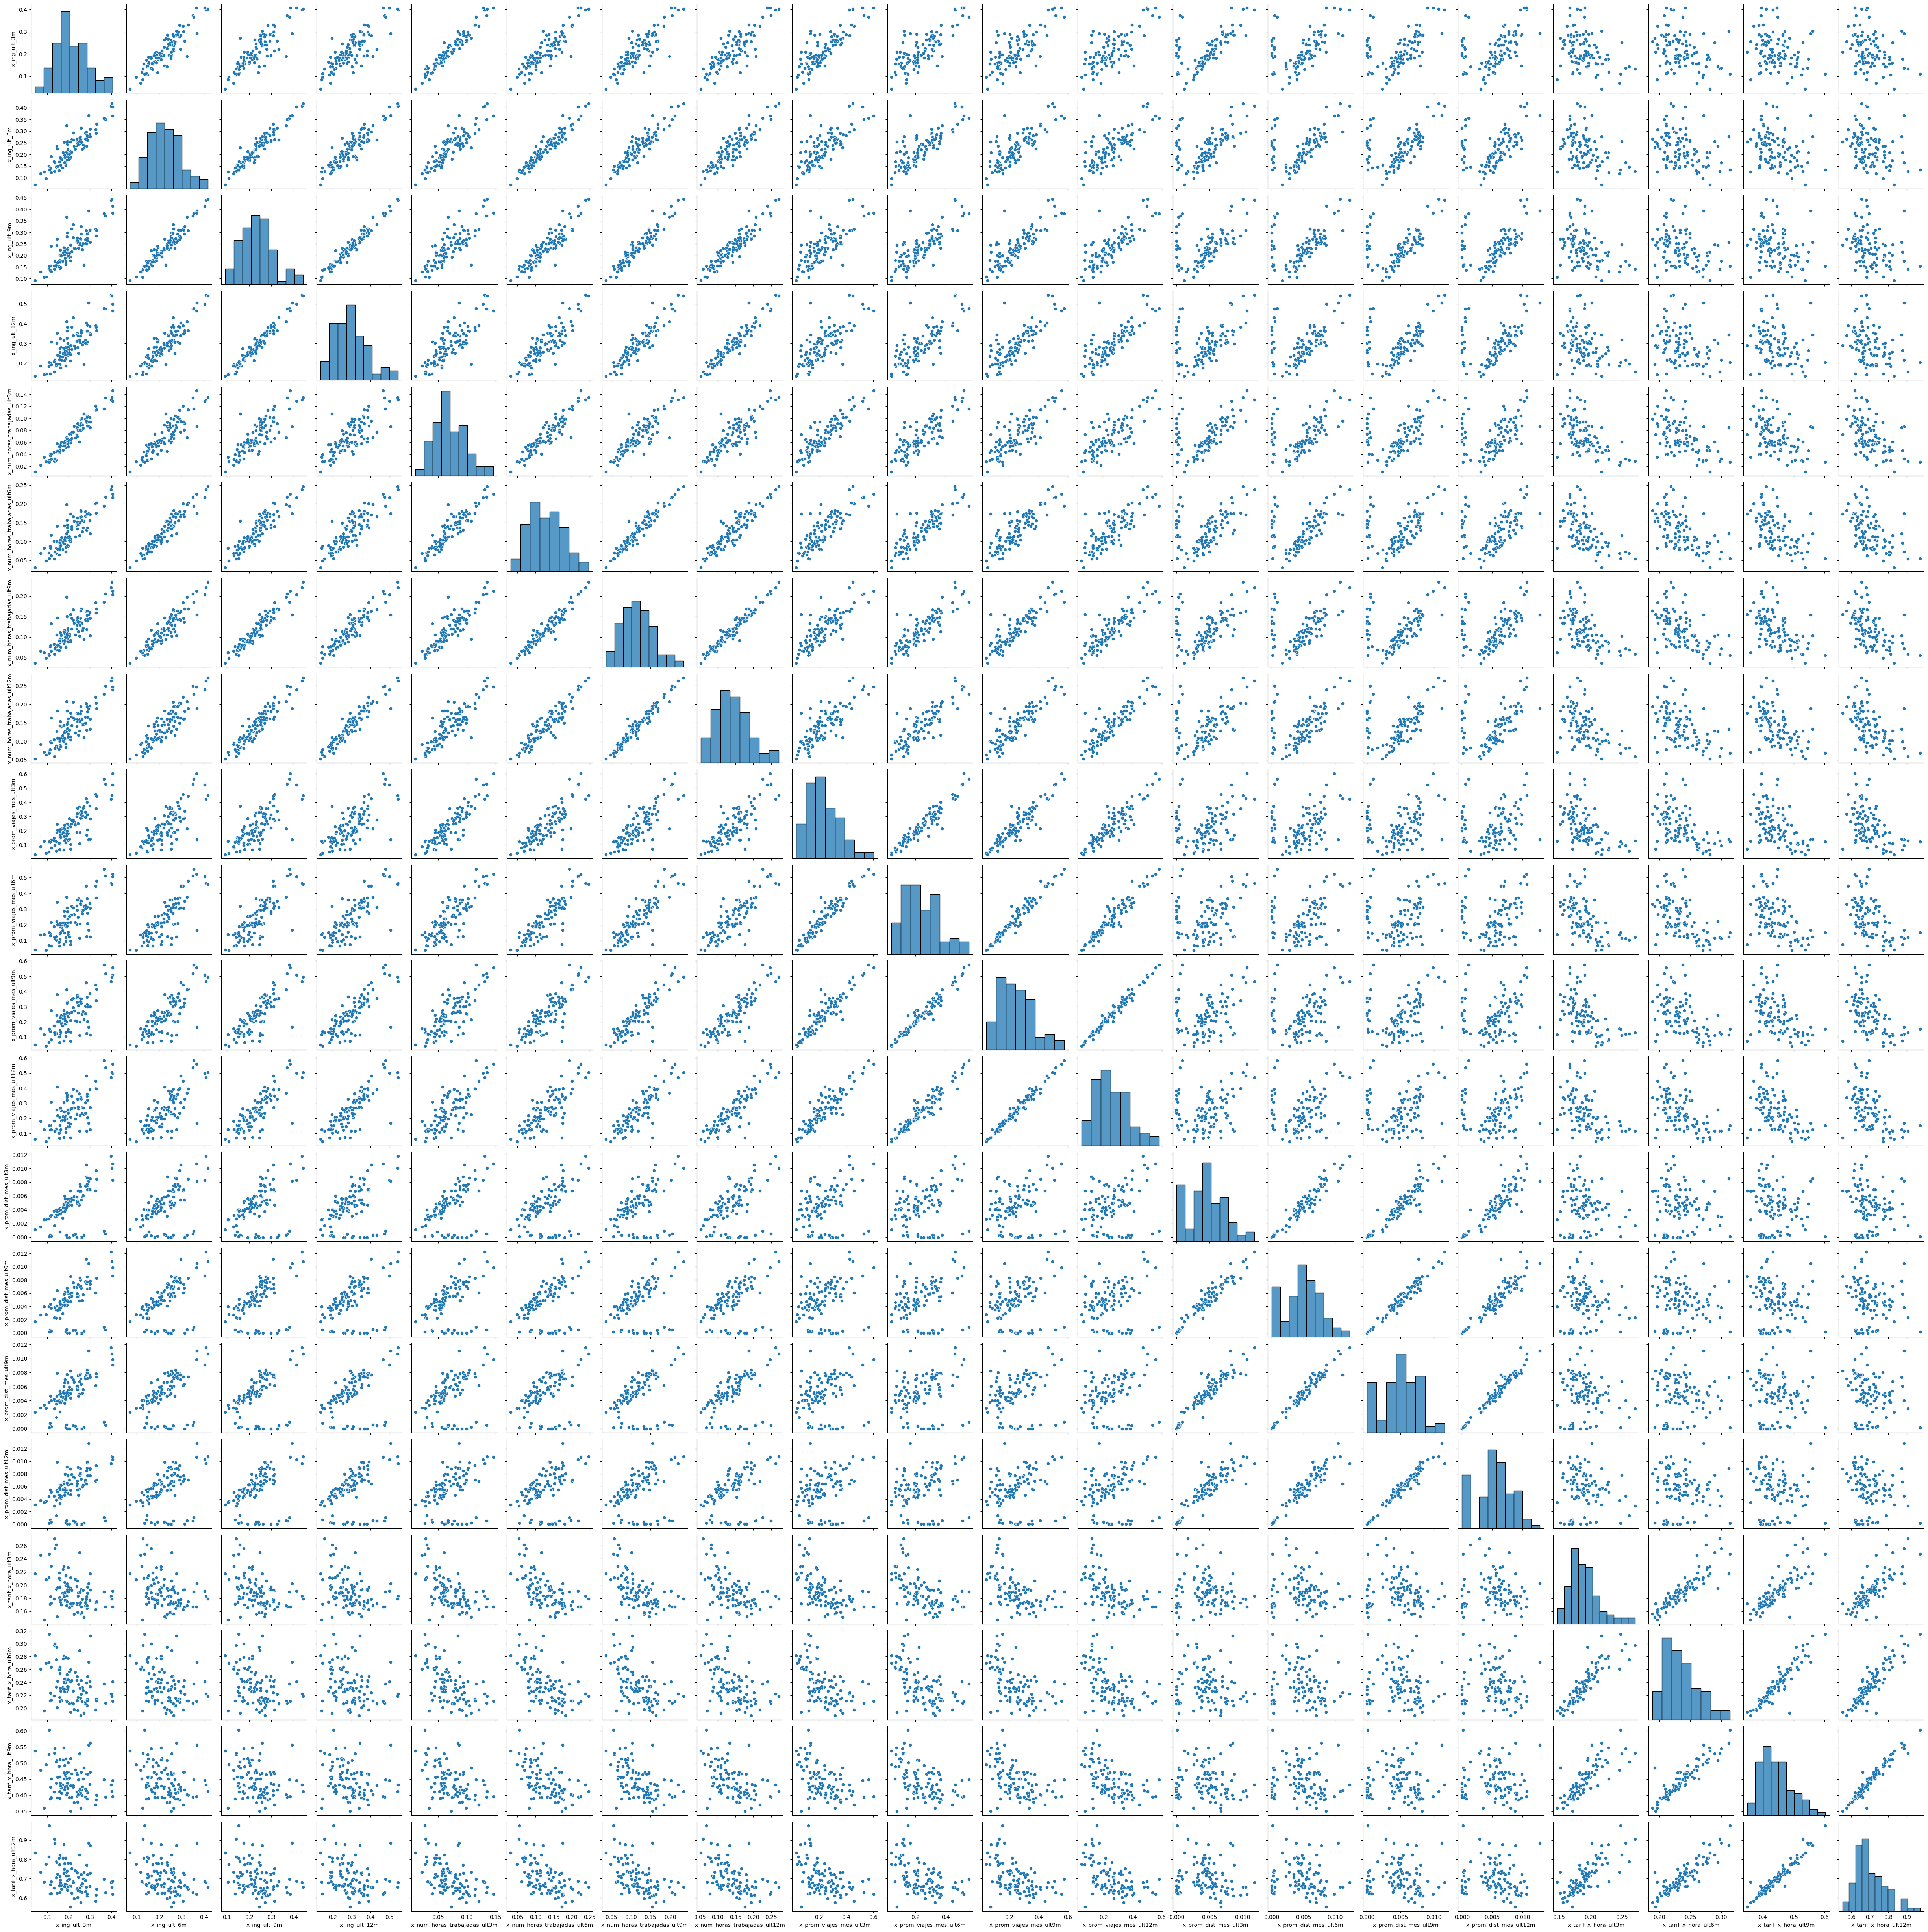

In [63]:
sns.pairplot(train.sample(100)[varc])

In [64]:
vc = VarClusHi(df=train,feat_list=varc)
vc.varclus()


In [65]:
vc.rsquare.sort_values(by=['Cluster','RS_Ratio'])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
6,0,x_num_horas_trabajadas_ult9m,0.932650,0.216444,0.085954
5,0,x_num_horas_trabajadas_ult6m,0.932015,0.221615,0.087341
7,0,x_num_horas_trabajadas_ult12m,0.894598,0.203219,0.132285
2,0,x_ing_ult_9m,0.888903,0.246941,0.147528
1,0,x_ing_ult_6m,0.882997,0.253515,0.156738
10,0,x_prom_viajes_mes_ult9m,0.859910,0.125513,0.160196
9,0,x_prom_viajes_mes_ult6m,0.859495,0.123358,0.160277
3,0,x_ing_ult_12m,0.856168,0.230625,0.186947
11,0,x_prom_viajes_mes_ult12m,0.831233,0.122821,0.192398
4,0,x_num_horas_trabajadas_ult3m,0.838233,0.201964,0.202706


In [66]:
mc = list(vc.rsquare.sort_values(by=['Cluster','RS_Ratio']).groupby('Cluster').first()['Variable'])
mc

['x_num_horas_trabajadas_ult9m',
 'x_tarif_x_hora_ult9m',
 'x_prom_dist_mes_ult6m']

array([[<Axes: title={'center': 'x_num_horas_trabajadas_ult9m'}>,
        <Axes: title={'center': 'x_tarif_x_hora_ult9m'}>],
       [<Axes: title={'center': 'x_prom_dist_mes_ult6m'}>, <Axes: >]],
      dtype=object)

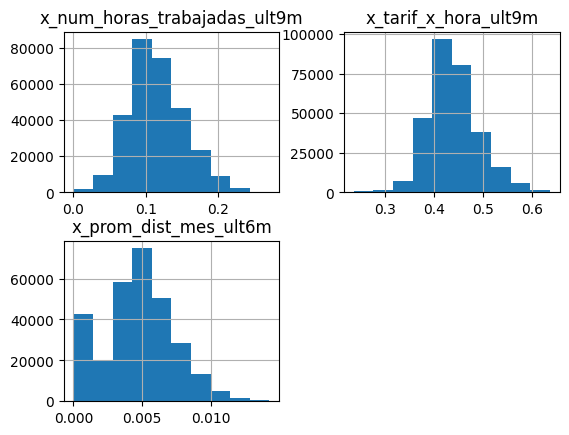

In [67]:
train[mc].hist()

### Poder predictivo

In [68]:
sk = SelectKBest(k=len(mc))
sk.fit(train[mc],train[vart[0]])

SelectKBest(k=3)

In [69]:
pd.Series(dict(zip(sk.feature_names_in_,sk.scores_))).sort_values(ascending=False)


x_num_horas_trabajadas_ult9m    2692.133817
x_prom_dist_mes_ult6m           1269.060874
x_tarif_x_hora_ult9m             400.038133
dtype: float64

In [70]:
best = mc[:]
best

['x_num_horas_trabajadas_ult9m',
 'x_tarif_x_hora_ult9m',
 'x_prom_dist_mes_ult6m']

## Aprendizaje

In [71]:
ann = MLPClassifier()

#### Híper-parametrización 

In [72]:
hp = {
    'hidden_layer_sizes': [(a,b,) for a in range(1,11) for b in range(1,11) ],
    'activation': ['relu', 'tanh', 'logistic','identity'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'max_iter': [1000]
}

In [73]:
reduce(lambda x,y:x*y,map(len,hp.values()))

3600

In [74]:
grid = RandomizedSearchCV(ann,
                          param_distributions=hp,
                          n_iter=5,
                          cv=5,
                          scoring='roc_auc',
                          n_jobs=-1,
                          verbose=True)

In [75]:
grid.fit(train[best],train[vart[0]])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=MLPClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic', 'identity'],
                                        'hidden_layer_sizes': [(1, 1), (1, 2),
                                                               (1, 3), (1, 4),
                                                               (1, 5), (1, 6),
                                                               (1, 7), (1, 8),
                                                               (1, 9), (1, 10),
                                                               (2, 1), (2, 2),
                                                               (2, 3), (2, 4),
                                                               (2, 5), (2, 6),
                                                               (2, 7), (2, 8),
                                                               (2, 9), (2, 10),
                                                               (3, 1), (3, 2),
                                                               (3, 3), (3, 4),
                                                               (3, 5), (3, 6),
                                                               (3, 7), (3, 8),
                                                               (3, 9), (3, 10), ...],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'max_iter': [1000],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   scoring='roc_auc', verbose=True)

In [76]:
ann = grid.best_estimator_
ann

MLPClassifier(activation='identity', hidden_layer_sizes=(1, 9),
              learning_rate='adaptive', max_iter=1000)

In [77]:
grid.best_score_,grid.best_params_

(np.float64(0.6999041978160594),
 {'solver': 'adam',
  'max_iter': 1000,
  'learning_rate': 'adaptive',
  'hidden_layer_sizes': (1, 9),
  'activation': 'identity'})

### Estimación de parámetros $\vec{\theta}$

In [78]:
ann.fit(train[best],train[vart[0]])

MLPClassifier(activation='identity', hidden_layer_sizes=(1, 9),
              learning_rate='adaptive', max_iter=1000)

### Validación de modelo

In [79]:
{'train': roc_auc_score(y_true=train[vart[0]],y_score=ann.predict_proba(train[best])[:,1]),
 'valid': roc_auc_score(y_true=valid[vart[0]],y_score=ann.predict_proba(valid[best])[:,1])
 }

{'train': np.float64(0.7019405173022581),
 'valid': np.float64(0.5792902303546781)}

## Reportes del modelo

In [80]:
train['proba'] = ann.predict_proba(train[best])[:,1]
valid['proba'] = ann.predict_proba(valid[best])[:,1]

In [87]:
train['r_proba'] = pd.cut(train['proba'],bins=[0,0.03,0.07,0.1,0.14,1],include_lowest=True).astype(str)
valid['r_proba'] = pd.cut(valid['proba'],bins=[0,0.03,0.07,0.1,0.14,1],include_lowest=True).astype(str)

In [88]:
pd.concat([train[vart+['r_proba']+um].groupby(vart+['r_proba']).count().reset_index().assign(muestra='train'),
valid[vart+['r_proba']+um].groupby(vart+['r_proba']).count().reset_index().assign(muestra='valid')],ignore_index=True).to_clipboard(index=False)

In [95]:
train[vart+['r_proba']+um].groupby(vart+['r_proba']+[um[-1]]).agg(**{'casos':(um[0],'count')}).to_clipboard()

In [86]:
train['proba'].describe()

count    295929.000000
mean          0.023715
std           0.017232
min           0.000727
25%           0.011513
50%           0.019957
75%           0.031186
max           0.181171
Name: proba, dtype: float64

In [99]:
aux = pd.concat([train[um+['proba']+vart].assign(sample='train'),
valid[um+['proba']+vart].assign(sample='valid')],ignore_index=True)

In [103]:
pd.Series(dict(zip(sorted(aux['fh'].unique()),[roc_auc_score(y_true=d[vart[0]],y_score=d['proba']) for m,d in aux.groupby('fh')]))).to_clipboard()